## Starting from scratch!

In [2]:
import dask.distributed
client = dask.distributed.Client()
client


# import dask.distributed
# import coiled


# cluster = coiled.Cluster(idle_timeout="5 minutes",
#                          n_workers=4,
#                          worker_memory="8 GiB",
#                          spot_policy="spot",
#                          #environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
#                          #container="mcr.microsoft.com/planetary-computer/python:latest",
#                          workspace="azure",
#                          )

# client = cluster.get_client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35369,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:37707,Total threads: 4
Dashboard: http://127.0.0.1:39745/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:37551,


In [3]:
import easysnowdata
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

In [4]:
bbox_gdf = gpd.read_file(
    "https://github.com/egagli/easysnowdata/raw/main/docs/examples/mt_rainier.geojson"
)

In [5]:
import fsspec
with fsspec.open('https://github.com/egagli/mgrs_tiles_snow_area/raw/main/mgrs_land_tiles_snow_area.parquet') as file:
    mgrs_gdf = gpd.read_parquet(file)
bbox_gdf = mgrs_gdf[mgrs_gdf.tile=='10TES']

In [6]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=bbox_gdf, start_date="2016-10-01", end_date="2017-09-30", resolution=80, units="linear power",
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.
Border noise removed from the data.
Added relative orbit number and orbit state as coordinates to the data.
Units remain in linear power. Convert to dB using the .linear_to_db() method.


In [7]:
s1_rtc_ds = s1.data #.persist() only do persist with coiled

In [8]:
#s1_rtc_ds.compute()

In [9]:
#s1_rtc_ds['vv'].plot.imshow(col='time', col_wrap=12, cmap='viridis', robust=True)

In [10]:
#s1_rtc_ds['vh'].plot.imshow(col='time', col_wrap=12, cmap='viridis', robust=True)

In [11]:
s1_rtc_ds

<xarray.Dataset> Size: 2GB
Dimensions:             (y: 1398, x: 1399, time: 157)
Coordinates:
  * y                   (y) float64 11kB 5.201e+06 5.201e+06 ... 5.089e+06
  * x                   (x) float64 11kB 5e+05 5e+05 ... 6.117e+05 6.118e+05
    spatial_ref         int32 4B 32610
  * time                (time) datetime64[ns] 1kB 2016-10-02T14:13:45.738916 ...
    sat:orbit_state     (time) object 1kB 'descending' ... 'ascending'
    sat:relative_orbit  (time) int16 314B 115 13 35 115 35 ... 115 13 115 35 64
Data variables:
    vh                  (time, y, x) float32 1GB dask.array<chunksize=(157, 512, 512), meta=np.ndarray>
    vv                  (time, y, x) float32 1GB dask.array<chunksize=(157, 512, 512), meta=np.ndarray>
Attributes:
    units:    linear power

In [45]:
def calculate_runoff_onset(s1_rtc_ds: xr.Dataset, min_acquisitions_during_melt: int, return_constituent_runoff_onsets: bool = False, returned_dates_format: str = 'dowy'):

    pixelwise_counts_per_orbit_and_polarization_ds = count_acquisitions_per_orbit_and_polarization(s1_rtc_ds)   

    backscatter_min_timing_per_orbit_and_polarization_ds = calculate_backscatter_min_per_orbit(s1_rtc_ds)

    constituent_runoff_onsets_ds = filter_insufficient_pixels_per_orbit_and_polarization(backscatter_min_timing_per_orbit_and_polarization_ds,pixelwise_counts_per_orbit_and_polarization_ds,min_acquisitions_during_melt)

    constituent_runoff_onsets_da = constituent_runoff_onsets_ds.to_dataarray(dim='polarization')
  

    if return_constituent_runoff_onsets==False:
        runoff_onset_da = calculate_runoff_onset_from_constituent_runoff_onsets(constituent_runoff_onsets_da)
    else:
        runoff_onset_da = constituent_runoff_onsets_da

    if returned_dates_format=='dowy':
        runoff_onset_da = xr_datetime_to_DOWY(runoff_onset_da, hemisphere='northern')
    elif returned_dates_format=='doy':
        runoff_onset_da = runoff_onset_da.dt.dayofyear
    elif returned_dates_format=='date':
        runoff_onset_da = runoff_onset_da
    else:
        raise ValueError('returned_dates_format must be either "doy", "dowy", or "date".')
    
    return runoff_onset_da



def count_acquisitions_per_orbit_and_polarization(s1_rtc_ds: xr.Dataset):
    print('Calculating pixelwise counts per orbit and polarization...')
    pixelwise_counts_per_orbit_and_polarization = s1_rtc_ds.groupby('sat:relative_orbit').count(dim='time')
    return pixelwise_counts_per_orbit_and_polarization

def calculate_backscatter_min_per_orbit(s1_rtc_ds: xr.Dataset):
    print('Calculating backscatter min per orbit...')
    backscatter_min_timing_per_orbit_and_polarization_ds = s1_rtc_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim='time'))
    return backscatter_min_timing_per_orbit_and_polarization_ds

def filter_insufficient_pixels_per_orbit_and_polarization(backscatter_min_timing_per_orbit_and_polarization_ds: xr.Dataset, pixelwise_counts_per_orbit: xr.Dataset, min_acquisitions_during_melt: int):
    print('Filtering insufficient pixels per orbit and polarization...')
    constituent_runoff_onsets_ds = backscatter_min_timing_per_orbit_and_polarization_ds.where(pixelwise_counts_per_orbit >= min_acquisitions_during_melt)
    return constituent_runoff_onsets_ds

def calculate_runoff_onset_from_constituent_runoff_onsets(constituent_runoff_onsets_da: xr.DataArray):
    print('Calculating runoff onset from constituent runoff onsets...')
    constituent_runoff_onsets_int64_da = constituent_runoff_onsets_da.astype('int64')
    runoff_onset_da = constituent_runoff_onsets_int64_da.where(lambda x: x > 0).median(dim=['sat:relative_orbit','polarization']).astype('datetime64[ns]')
    return runoff_onset_da

def xr_datetime_to_DOWY(date: xr.DataArray, hemisphere: str = 'northern', water_year: int = None):
    """
    Converts an xarray DataArray containing datetime objects to the Day of Water Year (DOWY) given a water year.
    
    The Day of Water Year (DOWY) is calculated as the number of days since the start of the water year.
    The start of the water year varies by hemisphere: it begins on October 1st in the northern hemisphere
    and on April 1st in the southern hemisphere.
    
    Parameters:
    - date (xr.DataArray): An xarray DataArray with datetime64 data type.
    - hemisphere (str, optional): The hemisphere to consider for calculating the water year start. 
                                  Defaults to 'northern'. Valid values are 'northern' and 'southern'.
    - water_year (int, optional): The water year to calculate the DOWY for. If not provided, the water year
                                  is determined from the maximum year present in the `date` DataArray.
    
    Returns:
    - xr.DataArray: An xarray DataArray containing the DOWY for each datetime in the input DataArray.
    Note:
    - This function assumes that the input dates are all within the same water year.
    """

    start_month = 10 if hemisphere == 'northern' else 4

    if water_year is not None:
        start_of_water_year = pd.Timestamp(year=water_year-1, month=start_month, day=1)
        dowy = (date - xr.DataArray(start_of_water_year)).dt.days + 1
    else:
        water_year = date.dt.year.values.max()
        start_of_water_year = pd.Timestamp(year=water_year-1, month=start_month, day=1)
        dowy = (date - xr.DataArray(start_of_water_year)).dt.days + 1
    
    return dowy

In [46]:
runoff_onset = calculate_runoff_onset(s1_rtc_ds, 5).compute()

Calculating pixelwise counts per orbit and polarization...
Calculating backscatter min per orbit...
Filtering insufficient pixels per orbit and polarization...
Calculating runoff onset from constituent runoff onsets...


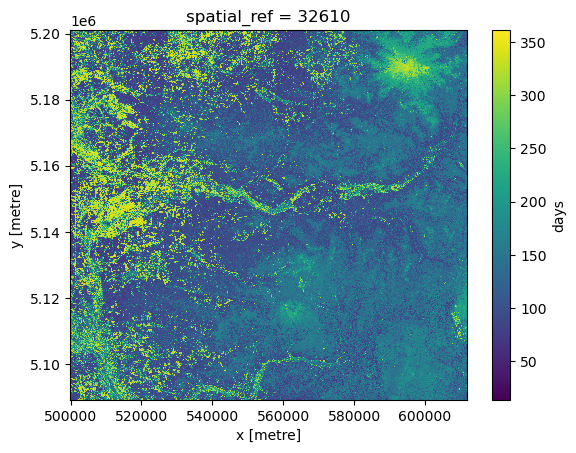

In [47]:
runoff_onset.plot.imshow()

In [15]:
# pd.to_datetime(runoff_onset.values[0][0])
# isinstance(runoff_onset.values[0][0],np.datetime64)
# date = pd.to_datetime(runoff_onset.values[0][0])
# runoff_onset.values.ravel() = pd.to_datetime(runoff_onset.values.ravel())

In [16]:
# def calculate_dowy(dates):
#     """
#     Convert numpy datetime64 array to day of water year (DOWY).
#     Water year starts on October 1st.
#     """
#     # Convert to pandas datetime to make it easier to work with
#     dates_pd = pd.to_datetime(dates)
    
#     # Calculate the start of the water year for each date
#     water_year_start = dates_pd - pd.offsets.MonthBegin(3)  # Offset to October 1st of the previous year
    
#     # Calculate DOWY
#     dowy = (dates_pd - water_year_start).days + 1
    
#     return dowy

# # Apply the function over the DataArray
# dowy_dataarray = xr.apply_ufunc(
#     calculate_dowy,
#     runoff_onset,
#     vectorize=True,  # Enable vectorized computation
#     dask='parallelized',  # Use Dask for parallel computation
#     input_core_dims=[[]],  # No core dimensions in input
#     output_dtypes=[int]  # Output type is integer
# )

#runoff_onset_dt64 = (runoff_onset - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
#runoff_onset_dt = xr.apply_ufunc(datetime.datetime.utcfromtimestamp, runoff_onset_dt64, vectorize=True)
#runoff_onset_datetime = xr.apply_ufunc(pd.to_datetime, runoff_onset, vectorize=True)
#runoff_onset_dt.dt.dayofyear.plot.imshow()

In [ ]:
# runoff_onset.dt.round('D').astype('datetime64[D]')

In [ ]:
# runoff_onset_years = runoff_onset.values.astype('datetime64[Y]').astype(int)+1970
# runoff_onset_months = runoff_onset.values.astype('datetime64[M]').astype(int)%12+1
# runoff_onset_days = (runoff_onset.values.astype('datetime64[D]')-runoff_onset.values.astype('datetime64[M]')).astype(int)+1

In [ ]:
# xr.apply_ufunc(pd.to_datetime, runoff_onset.astype('datetime64[D]'), vectorize=True)

In [ ]:
# def xr_dt_to_DOWY(date,hemisphere='northern'):
#     years = runoff_onset.values.astype('datetime64[Y]').astype(int)+1970
#     months = runoff_onset.values.astype('datetime64[M]').astype(int)%12+1
#     days = (runoff_onset.values.astype('datetime64[D]')-runoff_onset.values.astype('datetime64[M]')).astype(int)+1

#     try:
#         if hemisphere == 'northern':
#             start_month = 10
#         elif hemisphere == 'southern':
#             start_month = 4
#         else:
#             raise ValueError("Invalid hemisphere. Must be 'northern' or 'southern'.")

#         if hemisphere == 'northern':
#             if months < start_month:
#                 start_of_water_year = pd.Timestamp(year=years-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=years, month=start_month, day=1)
#         else:
#             if months < start_month:
#                 start_of_water_year = pd.Timestamp(year=years-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=years, month=start_month, day=1)
#         return (date - start_of_water_year).days + 1
#     except Exception as error:
#         print(error)
#         return np.nan


In [ ]:
# dowy = xr.apply_ufunc(
#     xr_dt_to_DOWY,  # The function to apply
#     runoff_onset,  # The input data array
#     vectorize=True,  # Enable vectorized execution
#     #input_core_dims=[[]],  # Specify that the function expects 0-dimensional inputs
#     #output_dtypes=[float]  # Specify the output data type
# )

In [ ]:
# def xr_datetime_to_DOWY(date, hemisphere: str = 'northern'):
#     """
#     Convert a datetime to the day of the water year (DOWY).
    
#     The water year starts on October 1 for the northern hemisphere and April 1 for the southern hemisphere.
    
#     Parameters:
#     date (datetime): The date to convert.
#     hemisphere (str): The hemisphere ('northern' or 'southern'). Default is 'northern'.
    
#     Returns:
#     int: The day of the water year, or np.nan if the date is not valid.
#     """
#     #date = pd.to_datetime(date)
#     #date = datetime.datetime(date)
#     try:
#         if hemisphere == 'northern':
#             start_month = 10
#         elif hemisphere == 'southern':
#             start_month = 4
#         else:
#             raise ValueError("Invalid hemisphere. Must be 'northern' or 'southern'.")

#         if hemisphere == 'northern':
#             if date.month < start_month:
#                 start_of_water_year = pd.Timestamp(year=date.year-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=date.year, month=start_month, day=1)
#         else:
#             if date.month < start_month:
#                 start_of_water_year = pd.Timestamp(year=date.year-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=date.year, month=start_month, day=1)
#         return (date - start_of_water_year).days + 1
#     except Exception as error:
#         print(error)
#         return np.nan

In [ ]:
# def xr_datetime_to_DOWY(date, hemisphere: str = 'northern'):
#     """
#     Convert a datetime to the day of the water year (DOWY).
    
#     The water year starts on October 1 for the northern hemisphere and April 1 for the southern hemisphere.
    
#     Parameters:
#     date (datetime): The date to convert.
#     hemisphere (str): The hemisphere ('northern' or 'southern'). Default is 'northern'.
    
#     Returns:
#     int: The day of the water year, or np.nan if the date is not valid.
#     """
#     #date = pd.to_datetime(date)
#     #date = datetime.datetime(date)
#     try:
#         if hemisphere == 'northern':
#             start_month = 10
#         elif hemisphere == 'southern':
#             start_month = 4
#         else:
#             raise ValueError("Invalid hemisphere. Must be 'northern' or 'southern'.")

#         if hemisphere == 'northern':
#             if date.month < start_month:
#                 start_of_water_year = pd.Timestamp(year=date.year-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=date.year, month=start_month, day=1)
#         else:
#             if date.month < start_month:
#                 start_of_water_year = pd.Timestamp(year=date.year-1, month=start_month, day=1)
#             else:
#                 start_of_water_year = pd.Timestamp(year=date.year, month=start_month, day=1)
#         return (date - start_of_water_year).days + 1
#     except Exception as error:
#         print(error)
#         return np.nan

In [ ]:
# hemisphere = 'northern'

# dowy = xr.apply_ufunc(
#     xr_datetime_to_DOWY,  # The function to apply
#     runoff_onset,  # The input data array
#     kwargs={'hemisphere': hemisphere},  # Additional arguments for xr_datetime_to_DOWY
#     vectorize=True,  # Enable vectorized execution
#     input_core_dims=[[]],  # Specify that the function expects 0-dimensional inputs
#     #output_dtypes=[float]  # Specify the output data type
# )

In [ ]:
# def calculate_dowy_without_datetime_conversion(dates, hemisphere='northern'):
#     """
#     Calculate the day of the water year (DOWY) without converting to datetime objects.
#     Assumes dates are in 'datetime64[ns]' format.
#     """
#     # Constants for the start month of the water year
#     start_month_northern = 10
#     start_month_southern = 4
    
#     # Extract year, month, and day as integers
#     years = dates.dt.year
#     months = dates.dt.month
#     days = dates.dt.day
    
#     # Determine the start month based on the hemisphere
#     start_month = start_month_northern if hemisphere == 'northern' else start_month_southern
    
#     # Compute the start of the water year
#     start_of_water_year = xr.where(months >= start_month, years, years - 1)
    
#     # Compute the day of year for both the current date and the start of the water year
#     doy = dates.dt.dayofyear
#     start_doy = xr.full_like(dates, np.datetime64('2000-01-01')).dt.dayofyear  # Placeholder leap year for consistent dayofyear calculation
#     start_doy = start_doy + ((start_month - 1) * 30.4375).astype(int)  # Approximate day of year for start of water year
    
#     # Adjust start_doy for leap years if necessary
#     is_leap_year = ((start_of_water_year % 4 == 0) & (start_of_water_year % 100 != 0)) | (start_of_water_year % 400 == 0)
#     start_doy = xr.where((is_leap_year & (start_month > 2)), start_doy + 1, start_doy)
    
#     # Calculate DOWY
#     dowy = doy - start_doy + 1
#     dowy = xr.where(dowy <= 0, dowy + 365, dowy)  # Adjust for dates before the start of the water year
#     dowy = xr.where((is_leap_year & (dowy > 365)), dowy - 1, dowy)  # Adjust for leap years
    
#     return dowy

In [ ]:
# def calculate_dowy_simple(runoff_onset, hemisphere='northern'):
#     """
#     Calculate the day of the water year (DOWY) in a more straightforward manner.
#     """
#     # Get the day of year for each date
#     doy = runoff_onset.dt.dayofyear

#     is_leap_year = runoff_onset.dt.is_leap_year
    
#     # Define the start day of the water year for each hemisphere
#     start_doy_northern = 274  # October 1st in a common year
#     start_doy_southern = 91   # April 1st
    
#     # Choose the correct start day based on the hemisphere
#     start_doy = start_doy_northern if hemisphere == 'northern' else start_doy_southern
    
#     # Calculate DOWY, adjusting for the start of the water year
#     dowy = doy - start_doy + 1

#     if hemisphere == 'southern':
#         # In a leap year, adjust the calculation for dates after February 28
#         if is_leap_year and doy >= start_doy_southern:
#             dowy = dowy + 1

#     # Handle wrap-around for dates before the start of the water year
#     dowy = xr.where(dowy <= 0, dowy + 365, dowy)
    
#     return dowy

In [ ]:
# hemisphere = 'northern'
# runoff_onset_dowy = calculate_dowy_simple(runoff_onset, hemisphere=hemisphere)

In [ ]:
# def calculate_dowy_simple(runoff_onset, hemisphere='northern'):
#     """
#     Calculate the day of the water year (DOWY) accounting for leap years and ensuring
#     the last day of the water year in the southern hemisphere during a leap year is 366.
#     """
#     # Get the day of year for each date
#     doy = runoff_onset.dt.dayofyear
#     month = runoff_onset.dt.month
    
    
#     # Define the start day of the water year for each hemisphere
#     start_doy_northern = 274  # October 1st in a common year
#     start_doy_southern = 91   # April 1st
    
#     # Adjust start day for leap years in the southern hemisphere
    
#     # Choose the correct start day based on the hemisphere
#     start_doy = start_doy_northern if hemisphere == 'northern' else start_doy_southern
    
#     # Calculate DOWY, adjusting for the start of the water year
#     dowy = doy - start_doy + 1
    
#     # Handle wrap-around for dates before the start of the water year
#     dowy = xr.where(dowy <= 0, dowy + 365, dowy)
    
    
#     return dowy

In [ ]:
# def calculate_dowy_simple(runoff_onset, hemisphere='northern'):
#     """
#     Calculate the day of the water year (DOWY) accounting for leap years and ensuring
#     the last day of the water year in the southern hemisphere during a leap year is 366.
#     """
#     # Assuming runoff_onset is an xarray DataArray with datetime-like data
#     year = runoff_onset.dt.year
#     year.min()


#     start_month = 10 if hemisphere == 'northern' else 4

#     # Calculate the water year's start year for each date
#     water_year_start = xr.where(month >= start_month, year, year - 1)

#     # Create a DataArray for the start of the water year
#     # This approach avoids using pd.to_datetime within the xarray operation
#     start_of_water_year = runoff_onset.copy()
#     start_of_water_year[:] = np.datetime64('NaT','D')  # Initialize with NaT
#     start_of_water_year = xr.where(
#         month >= start_month,
#         f"{water_year_start.astype(str)}-{start_month:02d}-01",
#         f"{(water_year_start - 1).astype(str)}-{start_month:02d}-01"
#     )

#     # Convert to datetime after string manipulation
# # Ensure start_of_water_year is a pandas Series before conversion
#     start_of_water_year_series = start_of_water_year.to_series()

#     # Now convert to datetime
#     start_of_water_year_datetime = pd.to_datetime(start_of_water_year_series.values.flatten(),errors='coerce')

#     # Convert back to xarray DataArray if necessary
#     start_of_water_year = xr.DataArray(start_of_water_year_datetime)

#     # Calculate DOWY
#     dowy = (runoff_onset - start_of_water_year).dt.days + 1

#     return dowy



In [ ]:
# def test_dowy_functions():
#     test_dates = [
#         # Northern Hemisphere: Water year starts on October 1st
#         "2022-09-30",  # Day before the start of the water year
#         "2022-10-01",  # Start of the water year
#         "2023-02-28",  # Day before leap day in a non-leap year
#         "2024-02-28",  # Day before leap day in a leap year
#         "2024-02-29",  # Leap day
#         "2024-03-01",  # Day after leap day
#         "2023-09-30",  # End of the water year
#         "2023-10-01",  # Start of the next water year
        
#         # Southern Hemisphere: Water year starts on April 1st
#         "2023-03-31",  # Day before the start of the water year
#         "2023-04-01",  # Start of the water year
#         "2023-02-28",  # Day before leap day in a non-leap year
#         "2024-02-28",  # Day before leap day in a leap year
#         "2024-02-29",  # Leap day
#         "2024-03-01",  # Day after leap day
#         "2024-03-31",  # End of the water year
#         "2024-04-01",  # Start of the next water year
        
#         # Additional random dates for broader coverage
#         "2023-01-15",  # Middle of winter in the northern hemisphere
#         "2023-07-15",  # Middle of summer in the northern hemisphere
#         "2023-11-15",  # Fall in the northern hemisphere
#         "2023-06-15",  # Winter in the southern hemisphere
#         "2023-12-15",  # Summer in the southern hemisphere
#     ]
#     hemispheres = ['northern', 'southern']
    
#     for hemisphere in hemispheres:
#         for date_str in test_dates:
#             date = pd.to_datetime(date_str)
#             runoff_onset = xr.DataArray([date])
            
#             # Convert to expected format for calculate_dowy_simple
#             dowy_simple = xr_datetime_to_DOWY(runoff_onset, hemisphere=hemisphere).values[0]
            
#             # Use datetime_to_DOWY
#             dowy = easysnowdata.utils.datetime_to_DOWY(date, hemisphere=hemisphere)
            
#             print(f"{date_str} in {hemisphere} hemisphere: new: {dowy_simple} vs utils: {dowy}")
#             assert dowy_simple == dowy, f"Mismatch for {date_str} in {hemisphere} hemisphere: {dowy_simple} vs {dowy}"

# # Run the tests
# test_dowy_functions()

In [ ]:
# unique_values, counts = np.unique(runoff_onset_dowy.values.ravel(),return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(f"Value: {value}, Count: {count}")

In [ ]:
# hemisphere = 'northern'
# runoff_onset_dowy = xr.apply_ufunc(calculate_dowy_without_datetime_conversion,runoff_onset,dask='parallelized', kwargs={'hemisphere': hemisphere}, output_dtypes=[np.float32],vectorize=True,dask_gufunc_kwargs={'allow_rechunk':True}) # check out last cell of https://github.com/egagli/MODIS_seasonal_snow_mask/blob/main/global_processing.ipynb

In [ ]:
# import inspect
# lines = inspect.getsource(easysnowdata.utils.datetime_to_DOWY)
# print(lines)

In [ ]:
# pixelwise_counts_ds = s1_rtc_ds.groupby('sat:relative_orbit').count(dim='time')
# min_acquisitions_during_melt_season = 5

# backscatter_min_timing_da = s1_rtc_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim='time')).where(pixelwise_counts_ds>=min_acquisitions_during_melt_season).to_dataarray(dim='polarization')

# backscatter_min_timing_da

# backscatter_min_timing_int64_da = backscatter_min_timing_da.astype('int64')

# median_backscatter_min_timing_da = backscatter_min_timing_int64_da.where(lambda x: x > 0).median(dim=['sat:relative_orbit','polarization']).astype('datetime64[ns]')

# median_backscatter_min_timing_da.dt.dayofyear.plot.imshow(cmap='twilight')

In [ ]:
# hemisphere = 'northern'
# runoff_onset_dowy = xr.apply_ufunc(easysnowdata.utils.datetime_to_DOWY,median_backscatter_min_timing_da,dask='parallelized', kwargs={'hemisphere': hemisphere}, output_dtypes=[np.float32],vectorize=True,dask_gufunc_kwargs={'allow_rechunk':True}) # check out last cell of https://github.com/egagli/MODIS_seasonal_snow_mask/blob/main/global_processing.ipynb

In [ ]:
# runoff_onset_dowy = runoff_onset_dowy.compute()

In [ ]:
# runoff_onset_dowy.plot.imshow()

In [ ]:
#cluster.scale(20)

In [ ]:
backscatter_min_timing_da.dt.dayofyear.plot.imshow(col='sat:relative_orbit', row='polarization', cmap='viridis', robust=True)

In [ ]:
s1_rtc_ds['vh'].groupby('sat:relative_orbit').count(dim='time').plot.imshow(col='sat:relative_orbit', col_wrap=4, cmap='viridis', robust=True)

In [ ]:
s1_rtc_ds.groupby('sat:relative_orbit').count(dim='time').to_dataarray().plot.imshow(col='sat:relative_orbit', row='variable',col_wrap=4, cmap='viridis', robust=True)

In [ ]:
all_nan_slices_vh = s1_rtc_ds['vh'].isnull().all(dim=['x', 'y']).compute()
valid_slices_vh = all_nan_slices_vh[~all_nan_slices_vh].time
s1_rtc_vh_ds = s1_rtc_ds['vh'].sel(time=valid_slices_vh)

In [ ]:
orbits_vh, counts_vh = np.unique(s1_rtc_vh_ds['sat:relative_orbit'],return_counts=True)

In [ ]:
min_acquisitions_during_melt_season = 2

In [ ]:
valid_orbits_vh = orbits_vh[counts_vh>min_acquisitions_during_melt_season]

In [ ]:
s1_rtc_valid_vh_ds = s1_rtc_vh_ds[s1_rtc_vh_ds['sat:relative_orbit'].isin(valid_orbits_vh)]

In [ ]:
pixelwise_counts_vh = s1_rtc_valid_vh_ds.groupby('sat:relative_orbit').count(dim='time')

In [ ]:
pixelwise_counts_vh.plot.imshow(col='sat:relative_orbit', cmap='viridis', robust=False)

In [ ]:
s1_rtc_valid_vh_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim='time')).where(pixelwise_counts_vh>=min_acquisitions_during_melt_season)

In [ ]:
.dt.dayofyear.plot.imshow(col='sat:relative_orbit')

In [ ]:
s1_rtc_ds['vh'].count(dim=['x', 'y']).plot()

In [ ]:
def get_orbits_with_melt_season_coverage(ts_ds,num_acquisitions_during_melt_season=6):
    # NEED TO SEPERATE OUT VALID ORBITS FOR VV AND VH
    year = ts_ds.time[0].dt.year.values
    unique_full_coverage = []
    melt_season = slice(f'{year}-02-01',f'{year}-07-31')
    
    for orbit in np.unique(ts_ds['sat:relative_orbit']):
        if len(ts_ds[ts_ds['sat:relative_orbit'].compute()==orbit].sel(time=melt_season).time.values) > num_acquisitions_during_melt_season:
            # if obs dont have more than a 1 month gap
            unique_full_coverage.append(orbit)
    unique_full_coverage = np.array(unique_full_coverage)
    
    return unique_full_coverage



def get_runoff_onset(ts_ds,return_seperate_orbits_and_polarizations=False, num_acquisitions_during_melt_season=8):
    # NEED TO SEPERATE OUT VALID ORBITS FOR VV AND VH
    #for pol in list(ts_ds.band.values):
    orbits = get_orbits_with_melt_season_coverage(ts_ds,num_acquisitions_during_melt_season=num_acquisitions_during_melt_season)
        #print(orbits)
    ts_ds = ts_ds[ts_ds['sat:relative_orbit'].isin(orbits).compute()]
    
    ts_ds = remove_border_noise(ts_ds)
    
    runoffs_int64 = ts_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim='time')).astype(np.int64)
    
    if return_seperate_orbits_and_polarizations==False: # if false (default), return median
        if 'band' in runoffs_int64.dims:
            runoffs_int64 = runoffs_int64.where(runoffs_int64>0).median(dim=['sat:relative_orbit','band'],skipna=True)
        else:
            runoffs_int64 = runoffs_int64.where(runoffs_int64>0).median(dim=['sat:relative_orbit'],skipna=True)
            
    return runoffs_int64.astype('datetime64[ns]')

def get_runoffs_onset(ts_ds):
    orbits = get_orbits_with_melt_season_coverage(ts_ds,num_acquisitions_during_melt_season=8)
    ts_ds = ts_ds[ts_ds['sat:relative_orbit'].isin(orbits)]
    runoffs = ts_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim='time'))
    return runoffs